## Masked and Non-masked

In [6]:
from acevedo_clss_and_fcns import * 
from sklearn.metrics import roc_curve, auc

device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
#tprs = []
#aucs = []
#base_fpr = np.linspace(0, 1, 101)






def test_model(modelo: GIN_classifier_to_explain_v2, loader: DataLoader, device: str = 'cpu'):
    
    modelo.eval()
    all_predictions = []
    all_true        = []
    tprs            = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    #correct = 0
    for i, val_data in enumerate(loader):
        
        assert not val_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            val_data.to(device, non_blocking=True) 
            assert val_data.is_cuda                          

        val_predictions = modelo(val_data.x, val_data.edge_index,  val_data.batch)# Make predictions for this batch
        pred            = val_predictions.argmax(dim=1)
        
        fpr, tpr, _ = roc_curve(pred.cpu().tolist(),  val_data.y.cpu().tolist())
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
        
        #all_predictions.extend(pred.cpu().tolist())
        #all_true.extend(val_data.y.cpu().tolist())

    return tprs #all_predictions, all_true    #correct += int((pred == val_data.y).sum())
        


def get_plot_data(tprs):
    base_fpr = np.linspace(0, 1, 101)
    aucs = []
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc




def get_plot_params(model, loader_validation):
    

    model.eval()

    tprs = test_model(model, loader_validation, device = 'cuda:0')



    return get_plot_data(tprs)

model_Masked_Phe            = torch.load(
                                    "./results/trained_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_12min_best_ValAcc_0.9200301772915881_epoch_83.pt")

loader_validation_Masked_Phe = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_validation_loader()



base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc = get_plot_params(model_Masked_Phe.to(device, non_blocking=True), loader_validation_Masked_Phe)



model_NON_Masked_Phe            = torch.load(
                                    "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_05min_best_ValAcc_0.9894379479441721_epoch_9.pt")

loader_validation_NON_Masked_Phe = torch.load("./results/dataloaders/loader_Concen_plus_Fluxes.pt").get_validation_loader()


base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 = get_plot_params(model_NON_Masked_Phe.to(device, non_blocking=True), loader_validation_NON_Masked_Phe)








#put_in_subplot(base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 , ax1, letter = 'a')

#put_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc, ax3, xlabel = 'False Positive Rate', letter = 'c')


device = 'cuda:0'


In [2]:



edge_weights_Non_masked = pd.read_parquet("./results/dataframes/Non_masked_edges_node_names_explainer_subgraphs.parquet.gzip").reset_index(drop=True)

edge_weights_Masked     = pd.read_parquet("./results/dataframes/Masked_edges_node_names_explainer_subgraphs.parquet.gzip").reset_index(drop=True)




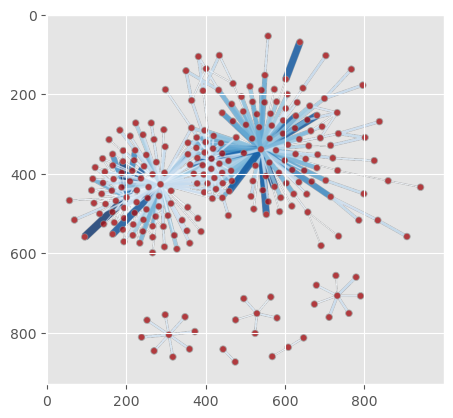

In [74]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from graph_tool import *
from graph_tool.draw import * 
import matplotlib


def export_graphml(edge_weights, graphml_path: str):
    
    edge_list = []
    for i, r in edge_weights[["node1","node2"]].iterrows():
        edge_list.append((r[0],r[1]))        
    G = nx.Graph()
    G.add_edges_from(edge_list)  
    scaler = MinMaxScaler(feature_range=(1, 10))
    weights = list(scaler.fit_transform(
        np.array(edge_weights.select_dtypes(include=np.number).sum(axis=1)).reshape(-1, 1)).squeeze()
    )
    w  = dict(zip(G.edges() , weights))
    nx.set_edge_attributes(G, w, "weights")
    nx.write_graphml(G, graphml_path)

def export_visualization(graphml_path = "./results/graphs/Non_masked_edge_weights.graphml",
                         output_path  =  "./results/figures/Non_masked_weights_graph.png"):
    
    GT    = load_graph(graphml_path)
    pos = sfdp_layout(GT,  C=1,p=2,  theta= .005, r = 9, K = 3)
    graph_draw(GT, pos = pos, #bg_color = 'white', 
            output = output_path,
            edge_pen_width = GT._Graph__edge_properties.weights, 
            edge_color= GT._Graph__edge_properties.weights, vertex_size= 8,
            adjust_aspect = True, fit_view_ink = True,
            vcmap= (matplotlib.cm.PuBu, 1  ),
            ecmap= (matplotlib.cm.Blues, .8), elen = 5, output_size = (500, 500))
    
    
    
    
export_graphml(edge_weights_Non_masked,  "./results/graphs/Non_masked_edge_weights.graphml")    
export_visualization("./results/graphs/Non_masked_edge_weights.graphml",  "./results/figures/Non_masked_weights_graph.png")

export_graphml(edge_weights_Masked,  "./results/graphs/Masked_edge_weights.graphml")    
export_visualization("./results/graphs/Masked_edge_weights.graphml",  "./results/figures/Masked_weights_graph.png")

graph_1 = image.imread( "./results/figures/Non_masked_weights_graph.png")
graph_2 = image.imread( "./results/figures/Masked_weights_graph.png")
plt.imshow(graph_1)


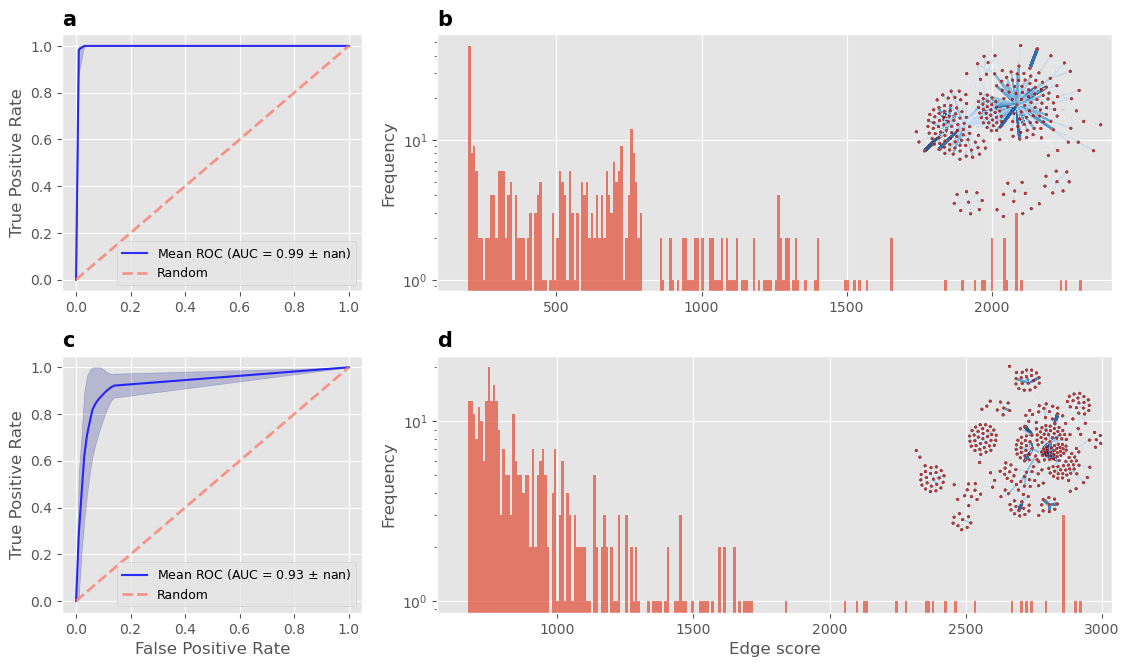

In [84]:
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox



score_array_NON_MASKED =  np.array(
edge_weights_Non_masked.select_dtypes(include=np.number).sum(axis=1))


score_array_MASKED =  np.array(
edge_weights_Masked.select_dtypes(include=np.number).sum(axis=1))

def place_image(im, loc=10, ax=None, zoom=1, **kw):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab       = AnchoredOffsetbox(loc='upper right', child=imagebox, pad=0., borderpad =0, frameon=False)
    ax.add_artist(ab)



plt.style.use('ggplot')   
fig = plt.figure(figsize=(15,6.5))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=3)
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=.8, top=0.99, wspace=0.25, hspace=0.25)

ax2.hist(score_array_NON_MASKED, log=True, bins = 250,  alpha = 0.7)
place_image(graph_1, loc=1, ax=ax2, pad=0, zoom=0.15)
ax2.set_title('b', fontsize = 15,  fontweight ="bold", loc='left')
ax2.set_ylabel('Frequency')


ax4.hist(score_array_MASKED, log=True, bins = 250,  alpha = 0.7)
place_image(graph_2, loc=1, ax=ax4, pad=0, zoom=0.15)
ax4.set_title('d', fontsize = 15,  fontweight ="bold", loc='left')
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Edge score')





def put_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'blue', alpha = 0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'navy', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'salmon', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=9)
    AX.set_ylabel('True Positive Rate')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 15,  fontweight ="bold", loc='left')

put_in_subplot(base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 , ax1, letter = 'a')

put_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc, ax3, xlabel = 'False Positive Rate', letter = 'c')


plt.savefig("./results/figures/Figure_2.png",
            bbox_inches ="tight",
            pad_inches = 0.01,
            transparent = False)

plt.show()




